# Exploratory Data Analysis

## Imports and constants

In [1]:
%load_ext autoreload
%autoreload 2

import os
from typing import Dict, Any
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from transformers import AutoTokenizer
from datasets import load_dataset

from defi_textmine_2025.data import (
    load_labeled_raw_data,
    load_test_raw_data,
    clean_raw_dataset,
    print_value_types,
    save_data,
    TextToMultiLabelDataGenerator,
)
from defi_textmine_2025.data import TARGET_COL, INPUT_COLS, INTERIM_DIR, EDA_DIR

VALIDATION_RATE = 0.25
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])

[22:16:27|INFO|config.py:58] PyTorch version 2.3.1 available.
[22:16:27|INFO|config.py:105] TensorFlow version 2.16.2 available.
/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Loading data

In [2]:
labeled_raw_df = load_labeled_raw_data()
labeled_raw_df

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."
...,...,...,...
1288,"M. Thibault Alekseï, membre de l'association ""...","[{""id"": 0, ""mentions"": [{""value"": ""perdu le co...","[[2, ""IS_PART_OF"", 3], [12, ""IS_IN_CONTACT_WIT..."
3822,Des employés d'une usine de production médical...,"[{""id"": 0, ""mentions"": [{""value"": ""grève"", ""st...","[[8, ""HAS_CONTROL_OVER"", 7], [4, ""HAS_CATEGORY..."
51266,"Le 13 mars 2001, Belgrade a connu un krach bou...","[{""id"": 0, ""mentions"": [{""value"": ""krach bours...","[[1, ""STARTED_IN"", 3], [10, ""IS_PART_OF"", 4], ..."


In [3]:
test_raw_df = load_test_raw_data()
test_raw_df

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."
4909,"48 heures après le braquage du ""DC Supermarket...","[{""id"": 0, ""mentions"": [{""value"": ""DC Supermar..."
2353,"À Genève, la boîte de nuit ""Pretty Woman"" a en...","[{""id"": 0, ""mentions"": [{""value"": ""tombé"", ""st..."
1210,"À Caracas, l'an dernier, une mine située à l'o...","[{""id"": 0, ""mentions"": [{""value"": ""effondremen..."
41948,"À Genève, une industrie de fabrication d'arbre...","[{""id"": 0, ""mentions"": [{""value"": ""incendiée"",..."
...,...,...
51452,"Le WOOP, une organisation mondiale, avait prop...","[{""id"": 0, ""mentions"": [{""value"": ""épidémie"", ..."
51491,"Madame Pautrat Elina, dirigeante de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."
51492,"Monsieur Elirone Trameur, membre de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."


## Analysing raw data

### Check value types

In [4]:
labeled_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 181 to 124
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       800 non-null    object
 1   entities   800 non-null    object
 2   relations  800 non-null    object
dtypes: object(3)
memory usage: 25.0+ KB


In [5]:
test_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1204 to 51742
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      400 non-null    object
 1   entities  400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [6]:
# types of values in train data
print_value_types(labeled_raw_df)

text <class 'str'>
entities <class 'str'>
relations <class 'str'>


In [7]:
# types of values in test data
print_value_types(test_raw_df)

text <class 'str'>
entities <class 'str'>


### Check for duplicated rows

In [8]:
labeled_raw_df[labeled_raw_df.duplicated()]

,text,entities,relations
id,,,


In [9]:
test_raw_df[test_raw_df.duplicated()]

,text,entities
id,,


### Check for missing values

In [10]:
labeled_raw_df.isnull().sum()

text         0
entities     0
relations    0
dtype: int64

In [11]:
test_raw_df.isnull().sum()

text        0
entities    0
dtype: int64

In [12]:
labeled_raw_df.relations.sort_values()

id
41601    [[0, "DEATHS_NUMBER", 14], [3, "RESIDES_IN", 4...
2514     [[0, "END_DATE", 11], [0, "IS_LOCATED_IN", 4],...
1223     [[0, "END_DATE", 11], [10, "START_DATE", 11], ...
2329     [[0, "END_DATE", 11], [4, "RESIDES_IN", 1], [0...
3898     [[0, "END_DATE", 9], [5, "OPERATES_IN", 7], [1...
                               ...                        
4964     [[9, "IS_LOCATED_IN", 5], [8, "OPERATES_IN", 5...
41071    [[9, "IS_LOCATED_IN", 5], [9, "IS_LOCATED_IN",...
31669    [[9, "IS_LOCATED_IN", 8], [11, "OPERATES_IN", ...
41918    [[9, "IS_LOCATED_IN", 8], [13, "HAS_CONTROL_OV...
155      [[9, "OPERATES_IN", 1], [0, "IS_LOCATED_IN", 4...
Name: relations, Length: 800, dtype: object

## Data Cleaning/Wrangling

### Fix value typing

In [13]:
labeled_clean_df = clean_raw_dataset(labeled_raw_df)
test_clean_df = clean_raw_dataset(test_raw_df)

In [14]:
assert (labeled_raw_df.index == labeled_clean_df.index).all()
assert (test_raw_df.index == test_clean_df.index).all()

In [15]:
test_raw_df.head(1)

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."


In [16]:
test_clean_df.head(1)

,text,entities,relations
id,,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{'id': 0, 'mentions': [{'value': 'crash', 'st...",None


### Check value types

In [17]:
# types of values in train data
print_value_types(labeled_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations [  <class 'list'>  ]


In [18]:
# types of values in test data
print_value_types(test_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations <class 'NoneType'>


### Save cleaned datasets

For manual analysis

In [19]:
save_data(labeled_clean_df, os.path.join(INTERIM_DIR, "train_cleaned.csv"))
save_data(test_clean_df, os.path.join(INTERIM_DIR, "test_cleaned.csv"))

## Analyze clean data

### All relation types

In [20]:
relation_classes = set(
    sum(
        labeled_clean_df.relations.apply(
            lambda row: list({r for (e1, r, e2) in row})
        ).values.tolist(),
        [],
    )
)
print(len(relation_classes))
relation_classes

37


{'CREATED',
 'DEATHS_NUMBER',
 'DIED_IN',
 'END_DATE',
 'GENDER_FEMALE',
 'GENDER_MALE',
 'HAS_CATEGORY',
 'HAS_COLOR',
 'HAS_CONSEQUENCE',
 'HAS_CONTROL_OVER',
 'HAS_FAMILY_RELATIONSHIP',
 'HAS_FOR_HEIGHT',
 'HAS_FOR_LENGTH',
 'HAS_FOR_WIDTH',
 'HAS_LATITUDE',
 'HAS_LONGITUDE',
 'HAS_QUANTITY',
 'INITIATED',
 'INJURED_NUMBER',
 'IS_AT_ODDS_WITH',
 'IS_BORN_IN',
 'IS_BORN_ON',
 'IS_COOPERATING_WITH',
 'IS_DEAD_ON',
 'IS_IN_CONTACT_WITH',
 'IS_LOCATED_IN',
 'IS_OF_NATIONALITY',
 'IS_OF_SIZE',
 'IS_PART_OF',
 'IS_REGISTERED_AS',
 'OPERATES_IN',
 'RESIDES_IN',
 'STARTED_IN',
 'START_DATE',
 'WAS_CREATED_IN',
 'WAS_DISSOLVED_IN',
 'WEIGHS'}

#### Summary stats on relation classes

<Axes: xlabel='Number of texts containing the relation', ylabel='Relation'>

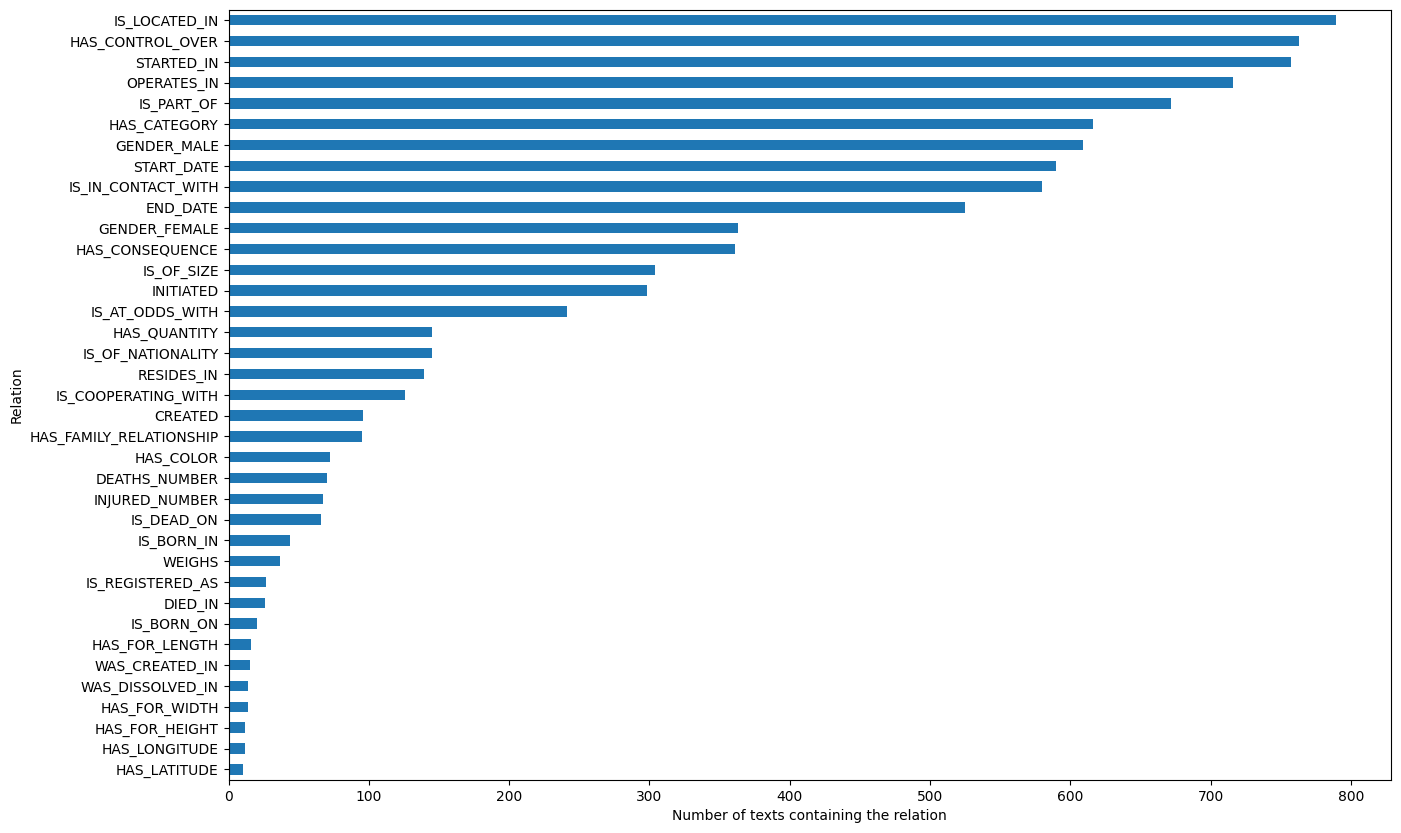

In [21]:
# number of text containing a relation category

plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df[labeled_raw_df.relations.str.contains(cat)].shape[0] for cat in relation_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of texts containing the relation", ylabel="Relation")

In [22]:
labeled_raw_df.relations.str.count("CREATED").sum()

141

In [23]:
# distribution of the occurences of each category among texts
pd.DataFrame({cat: labeled_raw_df.relations.str.count(cat) for cat in relation_classes}).describe().T.sort_values("50%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
IS_LOCATED_IN,800.0,11.28125,6.555025,0.0,7.0,10.0,15.0,44.0
HAS_CONTROL_OVER,800.0,5.68375,3.724389,0.0,3.0,5.0,8.0,22.0
STARTED_IN,800.0,2.32500,1.829223,0.0,1.0,2.0,3.0,12.0
OPERATES_IN,800.0,3.04375,2.650588,0.0,1.0,2.0,4.0,19.0
IS_IN_CONTACT_WITH,800.0,3.64875,4.583026,0.0,0.0,2.0,4.0,44.0
GENDER_MALE,800.0,1.13500,0.864702,0.0,1.0,1.0,2.0,4.0
START_DATE,800.0,1.29250,1.165608,0.0,0.0,1.0,2.0,7.0
IS_PART_OF,800.0,1.82750,1.642747,0.0,1.0,1.0,2.0,14.0
END_DATE,800.0,1.09250,1.081853,0.0,0.0,1.0,2.0,6.0
HAS_CATEGORY,800.0,1.11750,0.891452,0.0,1.0,1.0,2.0,5.0


In [24]:
labeled_raw_df.relations.str.count("IS_LOCATED_IN")

id
181      17
31669    14
51470     5
51332     3
1131      8
         ..
1288     14
3822      6
51266     7
51368    13
124      23
Name: relations, Length: 800, dtype: int64

In [25]:
labeled_clean_df.relations.loc[181]

[[0, 'STARTED_IN', 9],
 [7, 'IS_LOCATED_IN', 9],
 [5, 'IS_LOCATED_IN', 10],
 [1, 'GENDER_FEMALE', 1],
 [12, 'IS_LOCATED_IN', 10],
 [0, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 10],
 [13, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 10],
 [1, 'HAS_CATEGORY', 18],
 [5, 'IS_LOCATED_IN', 9],
 [9, 'IS_LOCATED_IN', 10],
 [14, 'IS_DEAD_ON', 15],
 [7, 'HAS_CATEGORY', 19],
 [12, 'IS_LOCATED_IN', 9],
 [0, 'IS_LOCATED_IN', 9],
 [7, 'GENDER_MALE', 7],
 [11, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 9],
 [14, 'HAS_CATEGORY', 20],
 [0, 'STARTED_IN', 10],
 [0, 'START_DATE', 15],
 [7, 'IS_LOCATED_IN', 10],
 [0, 'END_DATE', 15],
 [14, 'GENDER_MALE', 14],
 [12, 'IS_OF_SIZE', 22],
 [13, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 11],
 [13, 'IS_OF_SIZE', 21]]

In [26]:
# Total occurences of each category in the labeled dataset
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

IS_LOCATED_IN              9025
HAS_CONTROL_OVER           4547
IS_IN_CONTACT_WITH         2919
OPERATES_IN                2435
STARTED_IN                 1860
IS_AT_ODDS_WITH            1526
IS_PART_OF                 1462
START_DATE                 1034
GENDER_MALE                 908
HAS_CATEGORY                894
END_DATE                    874
HAS_CONSEQUENCE             769
INITIATED                   469
IS_OF_SIZE                  438
GENDER_FEMALE               414
IS_COOPERATING_WITH         372
HAS_FAMILY_RELATIONSHIP     222
RESIDES_IN                  222
HAS_QUANTITY                191
IS_OF_NATIONALITY           179
CREATED                     141
HAS_COLOR                    91
DEATHS_NUMBER                75
INJURED_NUMBER               70
IS_DEAD_ON                   68
IS_BORN_IN                   50
DIED_IN                      41
WEIGHS                       41
IS_REGISTERED_AS             34
IS_BORN_ON                   20
HAS_FOR_LENGTH               16
WAS_CREA

<Axes: title={'center': 'Total occurences of each category in the labeled dataset'}, xlabel='Number of labeled relations of a given category', ylabel='Category of relation'>

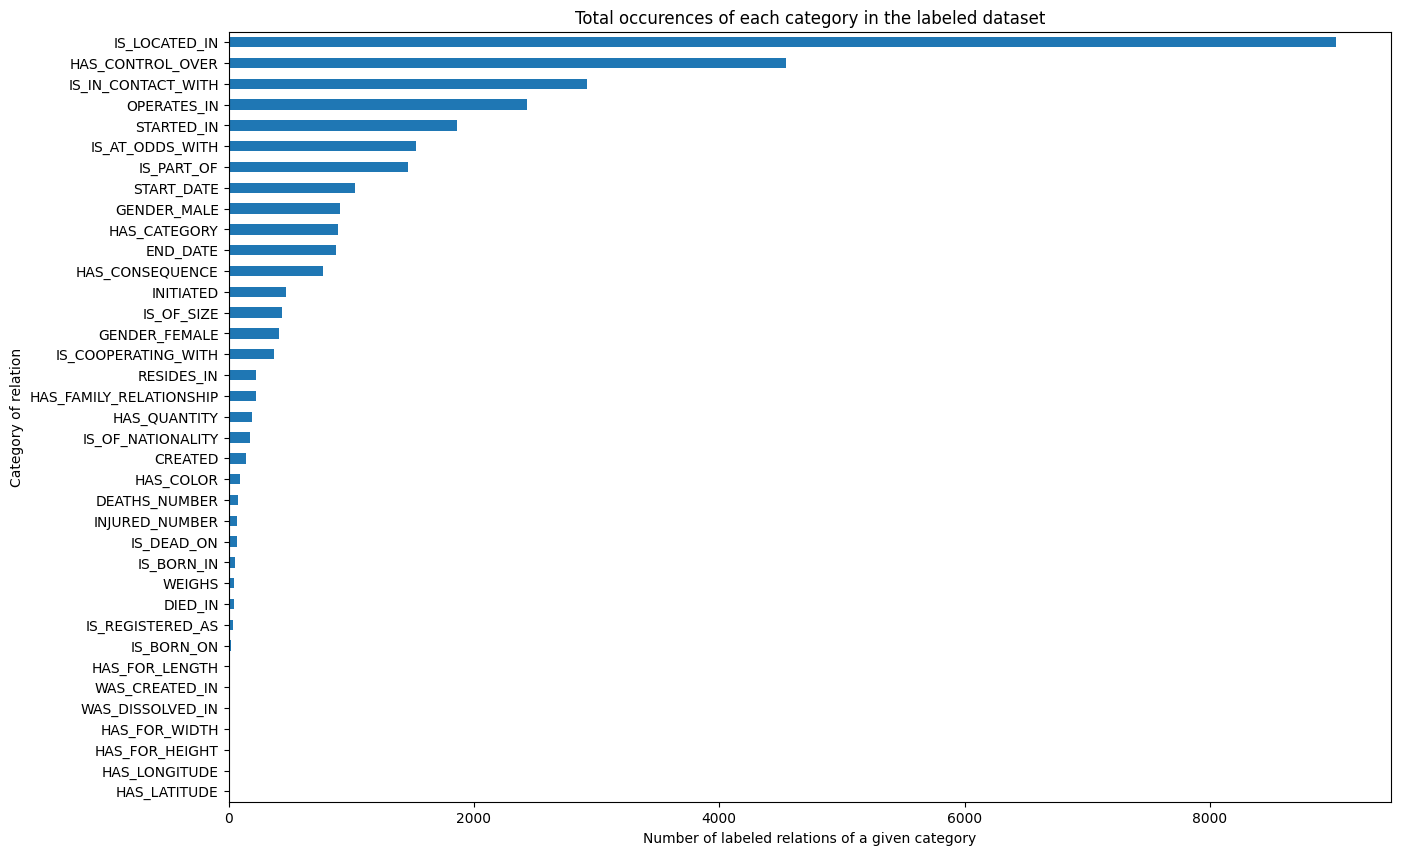

In [27]:
plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of labeled relations of a given category", ylabel="Category of relation", title="Total occurences of each category in the labeled dataset")
# pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

In [28]:
labeled_clean_df.entities.loc[181]

[{'id': 0,
  'mentions': [{'value': 'accident', 'start': 70, 'end': 78},
   {'value': 'accident de circulation', 'start': 100, 'end': 123},
   {'value': 'accident', 'start': 275, 'end': 283}],
  'type': 'ACCIDENT'},
 {'id': 1,
  'mentions': [{'value': 'Anam Destresse', 'start': 0, 'end': 14},
   {'value': 'Anam Destresse', 'start': 431, 'end': 445}],
  'type': 'CIVILIAN'},
 {'id': 2,
  'mentions': [{'value': 'moto', 'start': 148, 'end': 152},
   {'value': 'moto', 'start': 550, 'end': 554}],
  'type': 'MATERIEL'},
 {'id': 3,
  'mentions': [{'value': 'bus', 'start': 159, 'end': 162},
   {'value': 'bus', 'start': 208, 'end': 211},
   {'value': 'bus', 'start': 589, 'end': 592}],
  'type': 'MATERIEL'},
 {'id': 4,
  'mentions': [{'value': 'panneaux de signalisation',
    'start': 289,
    'end': 314}],
  'type': 'MATERIEL'},
 {'id': 5,
  'mentions': [{'value': 'blessés', 'start': 470, 'end': 477}],
  'type': 'GROUP_OF_INDIVIDUALS'},
 {'id': 6,
  'mentions': [{'value': 'hélicoptère', 'start':

In [29]:
labeled_clean_df.relations.loc[181]

[[0, 'STARTED_IN', 9],
 [7, 'IS_LOCATED_IN', 9],
 [5, 'IS_LOCATED_IN', 10],
 [1, 'GENDER_FEMALE', 1],
 [12, 'IS_LOCATED_IN', 10],
 [0, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 10],
 [13, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 10],
 [1, 'HAS_CATEGORY', 18],
 [5, 'IS_LOCATED_IN', 9],
 [9, 'IS_LOCATED_IN', 10],
 [14, 'IS_DEAD_ON', 15],
 [7, 'HAS_CATEGORY', 19],
 [12, 'IS_LOCATED_IN', 9],
 [0, 'IS_LOCATED_IN', 9],
 [7, 'GENDER_MALE', 7],
 [11, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 9],
 [14, 'HAS_CATEGORY', 20],
 [0, 'STARTED_IN', 10],
 [0, 'START_DATE', 15],
 [7, 'IS_LOCATED_IN', 10],
 [0, 'END_DATE', 15],
 [14, 'GENDER_MALE', 14],
 [12, 'IS_OF_SIZE', 22],
 [13, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 11],
 [13, 'IS_OF_SIZE', 21]]

In [30]:
labeled_raw_df[labeled_raw_df.relations.str.contains("GENDER")]

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."
...,...,...,...
1288,"M. Thibault Alekseï, membre de l'association ""...","[{""id"": 0, ""mentions"": [{""value"": ""perdu le co...","[[2, ""IS_PART_OF"", 3], [12, ""IS_IN_CONTACT_WIT..."
3822,Des employés d'une usine de production médical...,"[{""id"": 0, ""mentions"": [{""value"": ""grève"", ""st...","[[8, ""HAS_CONTROL_OVER"", 7], [4, ""HAS_CATEGORY..."
51266,"Le 13 mars 2001, Belgrade a connu un krach bou...","[{""id"": 0, ""mentions"": [{""value"": ""krach bours...","[[1, ""STARTED_IN"", 3], [10, ""IS_PART_OF"", 4], ..."


### All entity types

In [31]:
entity_classes = set(
    sum(
        labeled_clean_df.entities.apply(
            lambda row: list({e["type"] for e in row})
        ).values.tolist(),
        [],
    )
)
print(len(entity_classes))
entity_classes

55


{'ACCIDENT',
 'AGITATING_TROUBLE_MAKING',
 'BOMBING',
 'CATEGORY',
 'CBRN_EVENT',
 'CIVILIAN',
 'CIVIL_WAR_OUTBREAK',
 'COLOR',
 'COUP_D_ETAT',
 'CRIMINAL_ARREST',
 'DEMONSTRATION',
 'DRUG_OPERATION',
 'ECONOMICAL_CRISIS',
 'ELECTION',
 'EPIDEMIC',
 'FIRE',
 'FIRSTNAME',
 'GATHERING',
 'GROUP_OF_INDIVIDUALS',
 'HEIGHT',
 'HOOLIGANISM_TROUBLEMAKING',
 'ILLEGAL_CIVIL_DEMONSTRATION',
 'INTERGOVERNMENTAL_ORGANISATION',
 'LASTNAME',
 'LATITUDE',
 'LENGTH',
 'LONGITUDE',
 'MATERIAL_REFERENCE',
 'MATERIEL',
 'MILITARY',
 'MILITARY_ORGANISATION',
 'NATIONALITY',
 'NATURAL_CAUSES_DEATH',
 'NATURAL_EVENT',
 'NON_GOVERNMENTAL_ORGANISATION',
 'NON_MILITARY_GOVERNMENT_ORGANISATION',
 'PLACE',
 'POLITICAL_VIOLENCE',
 'POLLUTION',
 'QUANTITY_EXACT',
 'QUANTITY_FUZZY',
 'QUANTITY_MAX',
 'QUANTITY_MIN',
 'RIOT',
 'STRIKE',
 'SUICIDE',
 'TERRORIST_OR_CRIMINAL',
 'THEFT',
 'TIME_EXACT',
 'TIME_FUZZY',
 'TIME_MAX',
 'TIME_MIN',
 'TRAFFICKING',
 'WEIGHT',
 'WIDTH'}

#### Summary stats on entity classes

* entity type frequencies

In [32]:
labeled_raw_df[labeled_raw_df.entities.str.contains("MATERIEL")].head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."


<Axes: xlabel='Number of texts containing the entity', ylabel='Entity'>

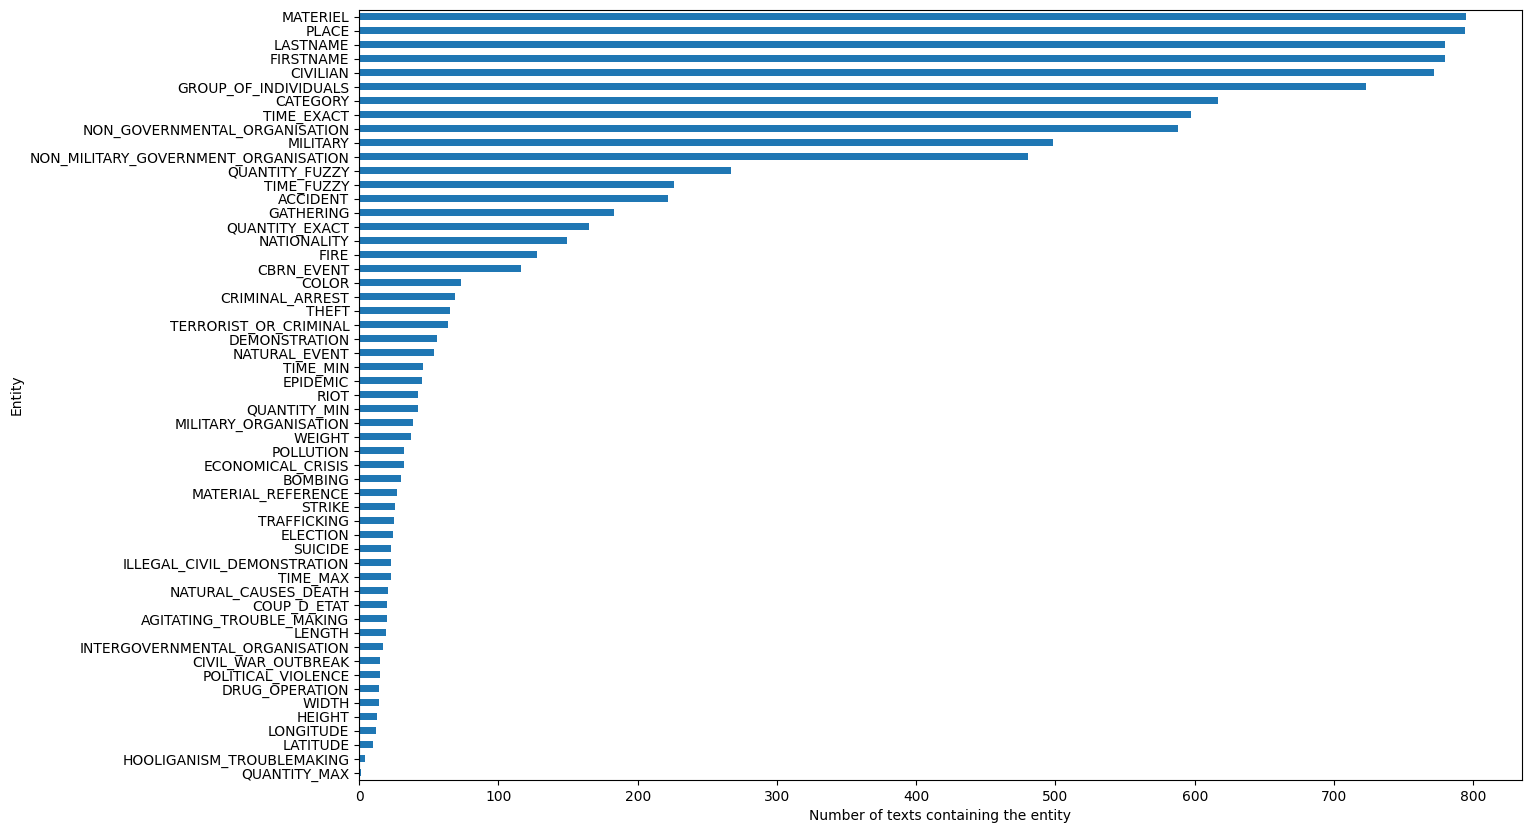

In [33]:
plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df[labeled_raw_df.entities.str.contains(cat)].shape[0] for cat in entity_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of texts containing the entity", ylabel="Entity")

### Stats about the cooccurence between entity categories and relation categories

TODO: For each relation category:
- what is the number of time each entity category is e1?
- what is the number of time each entity category is e2?
- what pairs of entity categories are never into a relation?

In [34]:
labeled_clean_df.values

array([['Anam Destresse, président de l\'ONG "Ma passion", a été blessé dans un accident. Le 30 juin 2022, un accident de circulation s\'est produit entre une moto et un bus sur l\'autoroute de Saint-Marin en Italie. Le bus, qui transportait 20 passagers, appartenait à l\'ONG. Lors de l\'accident, les panneaux de signalisation ont été complètement endommagés et le garde du corps a été blessé. Au total, deux passagers sont morts sur le coup. Anam Destresse, qui faisait partie des blessés, a été transporté en hélicoptère jusqu\'à l\'hôpital. Le conducteur de la moto a été retrouvé mort en dessous du bus. Il conduisait sans permis et en état d\'ivresse.',
        list([{'id': 0, 'mentions': [{'value': 'accident', 'start': 70, 'end': 78}, {'value': 'accident de circulation', 'start': 100, 'end': 123}, {'value': 'accident', 'start': 275, 'end': 283}], 'type': 'ACCIDENT'}, {'id': 1, 'mentions': [{'value': 'Anam Destresse', 'start': 0, 'end': 14}, {'value': 'Anam Destresse', 'start': 431, 'en

In [35]:

entity_relation_cat_df  = pd.concat(
    [
        pd.DataFrame([[text_entities[e1_id]["type"], r_cat, text_entities[e2_id]["type"]] for e1_id, r_cat, e2_id in text_relations], columns=["e1_cat", "r_cat", "e2_cat"])
        for text, text_entities, text_relations in labeled_clean_df.values
    ],
    axis=0
)
logging.info(f"{entity_relation_cat_df.shape=}")
entity_relation_cat_df.head()

[22:16:29|INFO|1936712772.py:8] entity_relation_cat_df.shape=(31469, 3)


,e1_cat,r_cat,e2_cat
0,ACCIDENT,STARTED_IN,PLACE
1,CIVILIAN,IS_LOCATED_IN,PLACE
2,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE
3,CIVILIAN,GENDER_FEMALE,CIVILIAN
4,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE


In [36]:
print(len(relation_classes), relation_classes)
print(len(entity_classes), entity_classes)

37 {'HAS_LONGITUDE', 'IS_OF_SIZE', 'START_DATE', 'IS_BORN_ON', 'HAS_FOR_WIDTH', 'IS_BORN_IN', 'WAS_DISSOLVED_IN', 'IS_PART_OF', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY', 'GENDER_FEMALE', 'HAS_CATEGORY', 'INITIATED', 'IS_REGISTERED_AS', 'HAS_LATITUDE', 'DEATHS_NUMBER', 'WAS_CREATED_IN', 'IS_COOPERATING_WITH', 'WEIGHS', 'HAS_QUANTITY', 'INJURED_NUMBER', 'HAS_COLOR', 'CREATED', 'HAS_CONTROL_OVER', 'IS_AT_ODDS_WITH', 'HAS_FOR_HEIGHT', 'END_DATE', 'DIED_IN', 'GENDER_MALE', 'HAS_FOR_LENGTH', 'STARTED_IN', 'IS_IN_CONTACT_WITH', 'RESIDES_IN', 'HAS_FAMILY_RELATIONSHIP', 'OPERATES_IN', 'IS_DEAD_ON', 'HAS_CONSEQUENCE'}
55 {'TIME_EXACT', 'THEFT', 'PLACE', 'CIVIL_WAR_OUTBREAK', 'MATERIEL', 'HOOLIGANISM_TROUBLEMAKING', 'CATEGORY', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'LONGITUDE', 'NATURAL_EVENT', 'POLITICAL_VIOLENCE', 'TIME_MIN', 'LENGTH', 'CIVILIAN', 'TIME_FUZZY', 'NATIONALITY', 'EPIDEMIC', 'DEMONSTRATION', 'BOMBING', 'ELECTION', 'MATERIAL_REFERENCE', 'COUP_D_ETAT', 'NON_GOVERNMENTAL_ORGANISATION', 

In [37]:
entity_relation_cat_df.query("r_cat=='HAS_CONTROL_OVER'").e1_cat.value_counts(normalize=True)

e1_cat
CIVILIAN                                0.399604
GROUP_OF_INDIVIDUALS                    0.378051
NON_MILITARY_GOVERNMENT_ORGANISATION    0.100946
NON_GOVERNMENTAL_ORGANISATION           0.064878
TERRORIST_OR_CRIMINAL                   0.038707
MILITARY_ORGANISATION                   0.010336
MILITARY                                0.005938
INTERGOVERNMENTAL_ORGANISATION          0.001320
PLACE                                   0.000220
Name: proportion, dtype: float64

In [38]:
entity_relation_cat_df.query("r_cat=='HAS_CONTROL_OVER'").e2_cat.value_counts(normalize=True)

e2_cat
MATERIEL                                0.603035
PLACE                                   0.244117
NON_GOVERNMENTAL_ORGANISATION           0.071476
GROUP_OF_INDIVIDUALS                    0.038487
CIVILIAN                                0.020893
NON_MILITARY_GOVERNMENT_ORGANISATION    0.014295
TERRORIST_OR_CRIMINAL                   0.005058
MILITARY_ORGANISATION                   0.001979
MILITARY                                0.000440
INTERGOVERNMENTAL_ORGANISATION          0.000220
Name: proportion, dtype: float64

#### For a relation, how many times is an entity category e1 or e2?

In [39]:
# plt.figure(figsize=(15, 10))
df = pd.concat([entity_relation_cat_df.value_counts(normalize=False), entity_relation_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_relation_classes = len(relation_classes)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing relations vs. {n_entity_classes * n_relation_classes * n_entity_classes=} imaginable relations !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-r_cat-e2_cat-freq.csv")) #.plot.barh()
df

[22:16:29|INFO|39938676.py:5] 737 existing relations vs. n_entity_classes * n_relation_classes * n_entity_classes=111925 imaginable relations !


,e1_cat,r_cat,e2_cat,count,proportion
0,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE,2970,0.094379
1,CIVILIAN,IS_LOCATED_IN,PLACE,2037,0.064730
2,PLACE,IS_LOCATED_IN,PLACE,1319,0.041914
3,NON_MILITARY_GOVERNMENT_ORGANISATION,OPERATES_IN,PLACE,1269,0.040325
4,GROUP_OF_INDIVIDUALS,HAS_CONTROL_OVER,MATERIEL,1140,0.036226
...,...,...,...,...,...
732,NON_MILITARY_GOVERNMENT_ORGANISATION,WAS_CREATED_IN,TIME_EXACT,1,0.000032
733,PLACE,HAS_CONTROL_OVER,MATERIEL,1,0.000032
734,GATHERING,HAS_CONSEQUENCE,AGITATING_TROUBLE_MAKING,1,0.000032
735,FIRE,HAS_CONSEQUENCE,CRIMINAL_ARREST,1,0.000032


In [40]:
entity_relation_cat_df.query("r_cat=='STARTED_IN'").drop("r_cat", axis=1).value_counts().rename("count_STARTED_IN")

e1_cat                                e2_cat
ACCIDENT                              PLACE     404
FIRE                                  PLACE     223
GATHERING                             PLACE     215
CBRN_EVENT                            PLACE     212
CRIMINAL_ARREST                       PLACE      78
THEFT                                 PLACE      77
NATURAL_EVENT                         PLACE      75
RIOT                                  PLACE      60
EPIDEMIC                              PLACE      58
ECONOMICAL_CRISIS                     PLACE      56
STRIKE                                PLACE      43
DEMONSTRATION                         PLACE      40
POLLUTION                             PLACE      40
BOMBING                               PLACE      37
POLITICAL_VIOLENCE                    PLACE      29
SUICIDE                               PLACE      28
NATURAL_CAUSES_DEATH                  PLACE      26
TRAFFICKING                           PLACE      25
CIVIL_WAR_OUTBREAK 

In [41]:
entity_relation_cat_df.query("r_cat=='WAS_CREATED_IN'").drop("r_cat", axis=1).value_counts()

e1_cat                                e2_cat    
MATERIEL                              TIME_EXACT    7
NON_GOVERNMENTAL_ORGANISATION         TIME_EXACT    5
MATERIEL                              TIME_FUZZY    1
                                      TIME_MIN      1
NON_MILITARY_GOVERNMENT_ORGANISATION  TIME_EXACT    1
Name: count, dtype: int64

In [42]:
entity_relation_cat_df.query("e2_cat=='TIME_EXACT'").drop(["e1_cat", "e2_cat"], axis=1).value_counts()

r_cat           
START_DATE          908
END_DATE            780
IS_DEAD_ON           62
IS_BORN_ON           20
WAS_CREATED_IN       13
WAS_DISSOLVED_IN     13
Name: count, dtype: int64

In [43]:
entity_relation_cat_df.query("e2_cat=='TIME_FUZZY'").drop(["e1_cat", "e2_cat"], axis=1).value_counts()

r_cat           
START_DATE          85
END_DATE            65
IS_DEAD_ON           5
WAS_CREATED_IN       1
WAS_DISSOLVED_IN     1
Name: count, dtype: int64

In [44]:
# number of relation categories between a pair of entity categories
entity_relation_cat_df.drop_duplicates().groupby(["e1_cat", "e2_cat"]).count().sort_values(by="r_cat")

r_cat
e1_cat                               e2_cat                                     
ACCIDENT                             ACCIDENT                                  1
MILITARY                             NATIONALITY                               1
                                     CRIMINAL_ARREST                           1
                                     COUP_D_ETAT                               1
                                     CIVIL_WAR_OUTBREAK                        1
...                                                                          ...
NON_GOVERNMENTAL_ORGANISATION        NON_MILITARY_GOVERNMENT_ORGANISATION      6
NON_MILITARY_GOVERNMENT_ORGANISATION NON_MILITARY_GOVERNMENT_ORGANISATION      6
GROUP_OF_INDIVIDUALS                 NON_GOVERNMENTAL_ORGANISATION             6
CIVILIAN                             NON_GOVERNMENTAL_ORGANISATION             6
                                     CIVILIAN                                  7

[474 rows x 1 columns]

#### what pairs of entity categories are in any relationship in the train dataset?

In [45]:
entity_cat_pair_in_relation_df = entity_relation_cat_df[["e1_cat", "e2_cat"]]#.drop_duplicates(subset=["e1_cat", "e2_cat"])
entity_cat_pair_in_relation_df

,e1_cat,e2_cat
0,ACCIDENT,PLACE
1,CIVILIAN,PLACE
2,GROUP_OF_INDIVIDUALS,PLACE
3,CIVILIAN,CIVILIAN
4,GROUP_OF_INDIVIDUALS,PLACE
...,...,...
64,GROUP_OF_INDIVIDUALS,GROUP_OF_INDIVIDUALS
65,ACCIDENT,PLACE
66,FIRE,TIME_EXACT
67,GROUP_OF_INDIVIDUALS,PLACE


In [46]:
df = pd.concat([entity_cat_pair_in_relation_df.value_counts(normalize=False), entity_cat_pair_in_relation_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity category pairs in relation vs. {n_entity_classes * n_entity_classes=} imaginable entity category pairs !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-e2_cat-freq.csv")) #.plot.barh()
df

[22:16:30|INFO|871775664.py:3] 474 existing entity category pairs in relation vs. n_entity_classes * n_entity_classes=3025 imaginable entity category pairs !


,e1_cat,e2_cat,count,proportion
0,GROUP_OF_INDIVIDUALS,PLACE,3411,0.108392
1,CIVILIAN,PLACE,2717,0.086339
2,CIVILIAN,CIVILIAN,1895,0.060218
3,NON_MILITARY_GOVERNMENT_ORGANISATION,PLACE,1372,0.043598
4,PLACE,PLACE,1319,0.041914
...,...,...,...,...
469,POLITICAL_VIOLENCE,DEMONSTRATION,1,0.000032
470,EPIDEMIC,BOMBING,1,0.000032
471,EPIDEMIC,DEMONSTRATION,1,0.000032
472,PLACE,MATERIEL,1,0.000032


### How many times the relation involves 2 entities of the same type?

In [47]:
e1_cat_equal_e2_cat_df = entity_cat_pair_in_relation_df.query("e1_cat==e2_cat")
e1_cat_equal_e2_cat_df

,e1_cat,e2_cat
3,CIVILIAN,CIVILIAN
11,PLACE,PLACE
16,CIVILIAN,CIVILIAN
17,PLACE,PLACE
25,TERRORIST_OR_CRIMINAL,TERRORIST_OR_CRIMINAL
...,...,...
30,PLACE,PLACE
36,PLACE,PLACE
52,PLACE,PLACE
60,CIVILIAN,CIVILIAN


In [48]:
df = pd.concat([e1_cat_equal_e2_cat_df.value_counts(normalize=False), e1_cat_equal_e2_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity of identical categories in relation vs. {n_entity_classes=} imaginable entity category !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-equal-e2_cat-freq.csv")) #.plot.barh()
df

[22:16:30|INFO|1690103560.py:3] 29 existing entity of identical categories in relation vs. n_entity_classes=55 imaginable entity category !


,e1_cat,e2_cat,count,proportion
0,CIVILIAN,CIVILIAN,1895,0.412225
1,PLACE,PLACE,1319,0.286926
2,GROUP_OF_INDIVIDUALS,GROUP_OF_INDIVIDUALS,842,0.183163
3,ECONOMICAL_CRISIS,ECONOMICAL_CRISIS,97,0.021101
4,NON_GOVERNMENTAL_ORGANISATION,NON_GOVERNMENTAL_ORGANISATION,89,0.019360
5,TERRORIST_OR_CRIMINAL,TERRORIST_OR_CRIMINAL,77,0.016750
6,ACCIDENT,ACCIDENT,69,0.015010
7,NON_MILITARY_GOVERNMENT_ORGANISATION,NON_MILITARY_GOVERNMENT_ORGANISATION,56,0.012182
8,CBRN_EVENT,CBRN_EVENT,26,0.005656
9,MILITARY,MILITARY,22,0.004786


In [49]:
per_r_cat_e1_cat_equal_e2_cat_df = entity_relation_cat_df.query("e1_cat==e2_cat")
per_r_cat_e1_cat_equal_e2_cat_df

,e1_cat,r_cat,e2_cat
3,CIVILIAN,GENDER_FEMALE,CIVILIAN
11,PLACE,IS_LOCATED_IN,PLACE
16,CIVILIAN,GENDER_MALE,CIVILIAN
17,PLACE,IS_LOCATED_IN,PLACE
25,TERRORIST_OR_CRIMINAL,GENDER_MALE,TERRORIST_OR_CRIMINAL
...,...,...,...
30,PLACE,IS_LOCATED_IN,PLACE
36,PLACE,IS_LOCATED_IN,PLACE
52,PLACE,IS_LOCATED_IN,PLACE
60,CIVILIAN,GENDER_FEMALE,CIVILIAN


In [50]:
df = pd.concat([per_r_cat_e1_cat_equal_e2_cat_df.value_counts(normalize=False), per_r_cat_e1_cat_equal_e2_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity of identical categories in relation vs. {n_entity_classes=} imaginable entity category !")
df.to_csv(os.path.join(EDA_DIR, "per_r_cat-e1_cat-equal-e2_cat_df-freq.csv")) #.plot.barh()
df

[22:16:30|INFO|2498074872.py:3] 53 existing entity of identical categories in relation vs. n_entity_classes=55 imaginable entity category !


,e1_cat,r_cat,e2_cat,count,proportion
0,PLACE,IS_LOCATED_IN,PLACE,1319,0.286926
1,CIVILIAN,GENDER_MALE,CIVILIAN,831,0.180770
2,CIVILIAN,GENDER_FEMALE,CIVILIAN,403,0.087666
3,CIVILIAN,IS_IN_CONTACT_WITH,CIVILIAN,354,0.077007
4,GROUP_OF_INDIVIDUALS,IS_IN_CONTACT_WITH,GROUP_OF_INDIVIDUALS,332,0.072221
5,GROUP_OF_INDIVIDUALS,IS_AT_ODDS_WITH,GROUP_OF_INDIVIDUALS,220,0.047857
6,GROUP_OF_INDIVIDUALS,IS_PART_OF,GROUP_OF_INDIVIDUALS,219,0.047640
7,CIVILIAN,HAS_FAMILY_RELATIONSHIP,CIVILIAN,208,0.045247
8,ECONOMICAL_CRISIS,HAS_CONSEQUENCE,ECONOMICAL_CRISIS,97,0.021101
9,ACCIDENT,HAS_CONSEQUENCE,ACCIDENT,69,0.015010


#### what pairs of entity categories never have any relationship?

- we don't need to attempt to classify pairs of entities of these types

In [51]:
all_possible_entity_cat_pairs_df = pd.DataFrame([[e1_cat, e2_cat] for (e1_cat, e2_cat) in itertools.product(*[list(entity_classes)]*2)], columns=["e1_cat", "e2_cat"]).set_index(["e1_cat", "e2_cat"])
all_possible_entity_cat_pairs_df

Empty DataFrame
Columns: []
Index: [(TIME_EXACT, TIME_EXACT), (TIME_EXACT, THEFT), (TIME_EXACT, PLACE), (TIME_EXACT, CIVIL_WAR_OUTBREAK), (TIME_EXACT, MATERIEL), (TIME_EXACT, HOOLIGANISM_TROUBLEMAKING), (TIME_EXACT, CATEGORY), (TIME_EXACT, NON_MILITARY_GOVERNMENT_ORGANISATION), (TIME_EXACT, LONGITUDE), (TIME_EXACT, NATURAL_EVENT), (TIME_EXACT, POLITICAL_VIOLENCE), (TIME_EXACT, TIME_MIN), (TIME_EXACT, LENGTH), (TIME_EXACT, CIVILIAN), (TIME_EXACT, TIME_FUZZY), (TIME_EXACT, NATIONALITY), (TIME_EXACT, EPIDEMIC), (TIME_EXACT, DEMONSTRATION), (TIME_EXACT, BOMBING), (TIME_EXACT, ELECTION), (TIME_EXACT, MATERIAL_REFERENCE), (TIME_EXACT, COUP_D_ETAT), (TIME_EXACT, NON_GOVERNMENTAL_ORGANISATION), (TIME_EXACT, CRIMINAL_ARREST), (TIME_EXACT, ACCIDENT), (TIME_EXACT, QUANTITY_EXACT), (TIME_EXACT, QUANTITY_MIN), (TIME_EXACT, MILITARY), (TIME_EXACT, AGITATING_TROUBLE_MAKING), (TIME_EXACT, ILLEGAL_CIVIL_DEMONSTRATION), (TIME_EXACT, LATITUDE), (TIME_EXACT, QUANTITY_FUZZY), (TIME_EXACT, WIDTH), (TIME_EXACT, DRUG_OPERATION), (TIME_EXACT, INTERGOVERNMENTAL_ORGANISATION), (TIME_EXACT, TERRORIST_OR_CRIMINAL), (TIME_EXACT, STRIKE), (TIME_EXACT, NATURAL_CAUSES_DEATH), (TIME_EXACT, FIRE), (TIME_EXACT, TRAFFICKING), (TIME_EXACT, COLOR), (TIME_EXACT, GATHERING), (TIME_EXACT, MILITARY_ORGANISATION), (TIME_EXACT, LASTNAME), (TIME_EXACT, WEIGHT), (TIME_EXACT, QUANTITY_MAX), (TIME_EXACT, HEIGHT), (TIME_EXACT, CBRN_EVENT), (TIME_EXACT, SUICIDE), (TIME_EXACT, RIOT), (TIME_EXACT, ECONOMICAL_CRISIS), (TIME_EXACT, TIME_MAX), (TIME_EXACT, POLLUTION), (TIME_EXACT, FIRSTNAME), (TIME_EXACT, GROUP_OF_INDIVIDUALS), (THEFT, TIME_EXACT), (THEFT, THEFT), (THEFT, PLACE), (THEFT, CIVIL_WAR_OUTBREAK), (THEFT, MATERIEL), (THEFT, HOOLIGANISM_TROUBLEMAKING), (THEFT, CATEGORY), (THEFT, NON_MILITARY_GOVERNMENT_ORGANISATION), (THEFT, LONGITUDE), (THEFT, NATURAL_EVENT), (THEFT, POLITICAL_VIOLENCE), (THEFT, TIME_MIN), (THEFT, LENGTH), (THEFT, CIVILIAN), (THEFT, TIME_FUZZY), (THEFT, NATIONALITY), (THEFT, EPIDEMIC), (THEFT, DEMONSTRATION), (THEFT, BOMBING), (THEFT, ELECTION), (THEFT, MATERIAL_REFERENCE), (THEFT, COUP_D_ETAT), (THEFT, NON_GOVERNMENTAL_ORGANISATION), (THEFT, CRIMINAL_ARREST), (THEFT, ACCIDENT), (THEFT, QUANTITY_EXACT), (THEFT, QUANTITY_MIN), (THEFT, MILITARY), (THEFT, AGITATING_TROUBLE_MAKING), (THEFT, ILLEGAL_CIVIL_DEMONSTRATION), (THEFT, LATITUDE), (THEFT, QUANTITY_FUZZY), (THEFT, WIDTH), (THEFT, DRUG_OPERATION), (THEFT, INTERGOVERNMENTAL_ORGANISATION), (THEFT, TERRORIST_OR_CRIMINAL), (THEFT, STRIKE), (THEFT, NATURAL_CAUSES_DEATH), (THEFT, FIRE), (THEFT, TRAFFICKING), (THEFT, COLOR), (THEFT, GATHERING), (THEFT, MILITARY_ORGANISATION), (THEFT, LASTNAME), (THEFT, WEIGHT), ...]

[3025 rows x 0 columns]

In [52]:
entity_cat_pair_in_relation_df.drop_duplicates().set_index(["e1_cat", "e2_cat"])

,
e1_cat,e2_cat
ACCIDENT,PLACE
CIVILIAN,PLACE
GROUP_OF_INDIVIDUALS,PLACE
CIVILIAN,CIVILIAN
TERRORIST_OR_CRIMINAL,PLACE
...,...
CIVILIAN,COUP_D_ETAT
MILITARY,COUP_D_ETAT
COUP_D_ETAT,QUANTITY_FUZZY


In [53]:
entity_pairs_never_in_relation_df = pd.DataFrame(index=all_possible_entity_cat_pairs_df.index.difference(entity_cat_pair_in_relation_df.drop_duplicates().set_index(["e1_cat", "e2_cat"]).index)).reset_index(drop=False)
entity_pairs_never_in_relation_df.to_csv(os.path.join(EDA_DIR, "entity_pairs_never_in_relation.csv"))
entity_pairs_never_in_relation_df

,e1_cat,e2_cat
0,ACCIDENT,AGITATING_TROUBLE_MAKING
1,ACCIDENT,BOMBING
2,ACCIDENT,CATEGORY
3,ACCIDENT,CIVILIAN
4,ACCIDENT,CIVIL_WAR_OUTBREAK
...,...,...
2546,WIDTH,TIME_MAX
2547,WIDTH,TIME_MIN
2548,WIDTH,TRAFFICKING
2549,WIDTH,WEIGHT


### Text length

#### Number of chars

<Axes: >

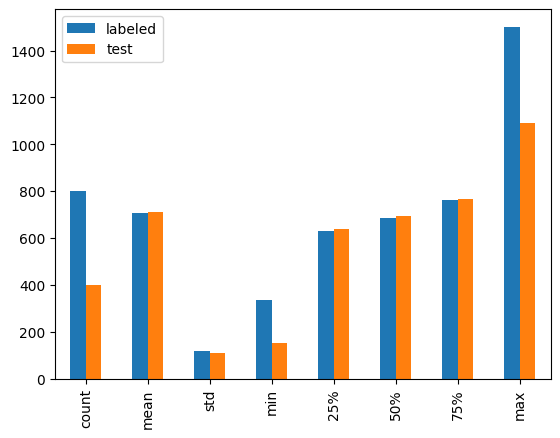

In [54]:
pd.DataFrame(
    {
        set_name: df.text.apply(len).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
).plot.bar()

#### Number of tokens (subwords from CamemBERT tokenizer)

<Axes: >

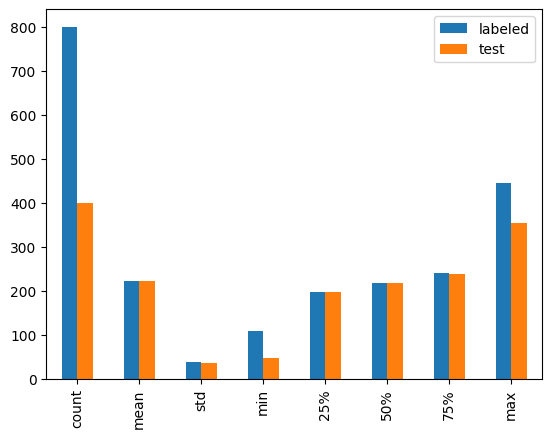

In [55]:
pd.DataFrame(
    {
        set_name: df.text.apply(count_tokens).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
).plot.bar()

## Generate interim datasets

for each text, generate a csv file containing all the generated texts annotated as a multilabeled Text classification task

The csv file is named after the index of the text in the raw data


In [61]:
excluded_entity_pairs = entity_pairs_never_in_relation_df.set_index(['e1_cat', 'e2_cat']).index.to_list()
excluded_entity_pairs

[('ACCIDENT', 'AGITATING_TROUBLE_MAKING'),
 ('ACCIDENT', 'BOMBING'),
 ('ACCIDENT', 'CATEGORY'),
 ('ACCIDENT', 'CIVILIAN'),
 ('ACCIDENT', 'CIVIL_WAR_OUTBREAK'),
 ('ACCIDENT', 'COLOR'),
 ('ACCIDENT', 'COUP_D_ETAT'),
 ('ACCIDENT', 'DEMONSTRATION'),
 ('ACCIDENT', 'DRUG_OPERATION'),
 ('ACCIDENT', 'ECONOMICAL_CRISIS'),
 ('ACCIDENT', 'ELECTION'),
 ('ACCIDENT', 'EPIDEMIC'),
 ('ACCIDENT', 'FIRSTNAME'),
 ('ACCIDENT', 'GATHERING'),
 ('ACCIDENT', 'GROUP_OF_INDIVIDUALS'),
 ('ACCIDENT', 'HEIGHT'),
 ('ACCIDENT', 'HOOLIGANISM_TROUBLEMAKING'),
 ('ACCIDENT', 'ILLEGAL_CIVIL_DEMONSTRATION'),
 ('ACCIDENT', 'INTERGOVERNMENTAL_ORGANISATION'),
 ('ACCIDENT', 'LASTNAME'),
 ('ACCIDENT', 'LATITUDE'),
 ('ACCIDENT', 'LENGTH'),
 ('ACCIDENT', 'LONGITUDE'),
 ('ACCIDENT', 'MATERIAL_REFERENCE'),
 ('ACCIDENT', 'MATERIEL'),
 ('ACCIDENT', 'MILITARY'),
 ('ACCIDENT', 'MILITARY_ORGANISATION'),
 ('ACCIDENT', 'NATIONALITY'),
 ('ACCIDENT', 'NATURAL_CAUSES_DEATH'),
 ('ACCIDENT', 'NATURAL_EVENT'),
 ('ACCIDENT', 'NON_GOVERNMENTAL_O

In [57]:
data_generator = TextToMultiLabelDataGenerator(excluded_entity_pairs=excluded_entity_pairs)
# data_generator = TextToMultiLabelDataGenerator(excluded_entity_pairs=[])
entity_pair_to_relations_df = data_generator.convert_relations_to_dataframe(labeled_clean_df.relations.loc[181])
entity_pair_to_relations_df

[22:16:30|INFO|data.py:117] self.excluded_entity_pairs=[('ACCIDENT', 'AGITATING_TROUBLE_MAKING'), ('ACCIDENT', 'BOMBING'), ('ACCIDENT', 'CATEGORY'), ('ACCIDENT', 'CIVILIAN'), ('ACCIDENT', 'CIVIL_WAR_OUTBREAK'), ('ACCIDENT', 'COLOR'), ('ACCIDENT', 'COUP_D_ETAT'), ('ACCIDENT', 'DEMONSTRATION'), ('ACCIDENT', 'DRUG_OPERATION'), ('ACCIDENT', 'ECONOMICAL_CRISIS'), ('ACCIDENT', 'ELECTION'), ('ACCIDENT', 'EPIDEMIC'), ('ACCIDENT', 'FIRSTNAME'), ('ACCIDENT', 'GATHERING'), ('ACCIDENT', 'GROUP_OF_INDIVIDUALS'), ('ACCIDENT', 'HEIGHT'), ('ACCIDENT', 'HOOLIGANISM_TROUBLEMAKING'), ('ACCIDENT', 'ILLEGAL_CIVIL_DEMONSTRATION'), ('ACCIDENT', 'INTERGOVERNMENTAL_ORGANISATION'), ('ACCIDENT', 'LASTNAME'), ('ACCIDENT', 'LATITUDE'), ('ACCIDENT', 'LENGTH'), ('ACCIDENT', 'LONGITUDE'), ('ACCIDENT', 'MATERIAL_REFERENCE'), ('ACCIDENT', 'MATERIEL'), ('ACCIDENT', 'MILITARY'), ('ACCIDENT', 'MILITARY_ORGANISATION'), ('ACCIDENT', 'NATIONALITY'), ('ACCIDENT', 'NATURAL_CAUSES_DEATH'), ('ACCIDENT', 'NATURAL_EVENT'), ('ACCID

,e1,e2,relations
0,0,9,"[IS_LOCATED_IN, STARTED_IN]"
1,7,9,[IS_LOCATED_IN]
2,5,10,[IS_LOCATED_IN]
3,1,1,[GENDER_FEMALE]
4,12,10,[IS_LOCATED_IN]
5,0,10,"[STARTED_IN, IS_LOCATED_IN]"
6,1,10,[IS_LOCATED_IN]
7,13,9,[IS_LOCATED_IN]
8,14,10,[IS_LOCATED_IN]
9,1,18,[HAS_CATEGORY]


In [62]:
("ACCIDENT", "ACCIDENT") not in excluded_entity_pairs

True

In [69]:
generated_data_dir_path = os.path.join(INTERIM_DIR, "multilabel_tagged_text_dataset")
# assert not os.path.exists(
#     generated_data_dir_path
# ), f"You must delete this folder first {generated_data_dir_path}!"

data_generator = TextToMultiLabelDataGenerator(excluded_entity_pairs=excluded_entity_pairs)

for split_name, clean_df in zip(
    ["train", "test"],
    [labeled_clean_df, test_clean_df],
):
    dest_dir_path = os.path.join(generated_data_dir_path, split_name)
    for multilabel_data in (
        pb := tqdm(
            # data_generator.generate_row_multilabel_data(clean_df, only_w_relation=True if split_name!="test" else False),
            data_generator.generate_row_multilabel_data(clean_df, only_w_relation=False),
            total=clean_df.shape[0],
            desc=f"{dest_dir_path} <- ",
        )
    ):
        text_index = multilabel_data.iloc[0][data_generator.text_index_col]
        dest_csv_file = os.path.join(dest_dir_path, f"{text_index}.csv")
        pb.set_description(f"{dest_csv_file} <-")
        save_data(multilabel_data, dest_csv_file, False)
        # break
    # break
multilabel_data

[22:29:33|INFO|data.py:117] self.excluded_entity_pairs=[('ACCIDENT', 'AGITATING_TROUBLE_MAKING'), ('ACCIDENT', 'BOMBING'), ('ACCIDENT', 'CATEGORY'), ('ACCIDENT', 'CIVILIAN'), ('ACCIDENT', 'CIVIL_WAR_OUTBREAK'), ('ACCIDENT', 'COLOR'), ('ACCIDENT', 'COUP_D_ETAT'), ('ACCIDENT', 'DEMONSTRATION'), ('ACCIDENT', 'DRUG_OPERATION'), ('ACCIDENT', 'ECONOMICAL_CRISIS'), ('ACCIDENT', 'ELECTION'), ('ACCIDENT', 'EPIDEMIC'), ('ACCIDENT', 'FIRSTNAME'), ('ACCIDENT', 'GATHERING'), ('ACCIDENT', 'GROUP_OF_INDIVIDUALS'), ('ACCIDENT', 'HEIGHT'), ('ACCIDENT', 'HOOLIGANISM_TROUBLEMAKING'), ('ACCIDENT', 'ILLEGAL_CIVIL_DEMONSTRATION'), ('ACCIDENT', 'INTERGOVERNMENTAL_ORGANISATION'), ('ACCIDENT', 'LASTNAME'), ('ACCIDENT', 'LATITUDE'), ('ACCIDENT', 'LENGTH'), ('ACCIDENT', 'LONGITUDE'), ('ACCIDENT', 'MATERIAL_REFERENCE'), ('ACCIDENT', 'MATERIEL'), ('ACCIDENT', 'MILITARY'), ('ACCIDENT', 'MILITARY_ORGANISATION'), ('ACCIDENT', 'NATIONALITY'), ('ACCIDENT', 'NATURAL_CAUSES_DEATH'), ('ACCIDENT', 'NATURAL_EVENT'), ('ACCID

data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/train/124.csv <-: 100%|██████████| 800/800 [02:05<00:00,  6.39it/s]  
data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/test/51742.csv <-: 100%|██████████| 400/400 [00:55<00:00,  7.16it/s]


,text_index,e1,e2,text,relations
0,51742,0,0,"Depuis le début du mois de décembre, des champ...",NaN
1,51742,1,0,"Depuis le début du mois de décembre, des champ...",NaN
2,51742,1,1,"Depuis le début du mois de décembre, des champ...",NaN
3,51742,2,0,"Depuis le début du mois de décembre, des champ...",NaN
4,51742,2,1,"Depuis le début du mois de décembre, des champ...",NaN
5,51742,1,2,"Depuis le début du mois de décembre, des champ...",NaN
6,51742,2,2,"Depuis le début du mois de décembre, des champ...",NaN
7,51742,1,3,"Depuis le début du mois de décembre, des champ...",NaN
8,51742,2,3,"Depuis le début du mois de décembre, des champ...",NaN
9,51742,1,4,"Depuis le début du mois de décembre, des champ...",NaN


## Check tagged text size using a  data loader to load data from csv files

to know wether the will fit at the input of the model (i.e. max of 512 tokens)

##### add special tokens to the tokenizer

In [70]:
# define special tokens to add to the tokenizer
task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [
    f"<{entity_class}>" for entity_class in entity_classes
]
# task_special_tokens

In [71]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


59

In [72]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30522: AddedToken("<e1>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30523: AddedToken("</

### initialize the data loader

In [73]:
interim_dataset = load_dataset(
    "csv",
    name="multilabel_tagged_text_dataset",
    data_dir="data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/",
    streaming=False,
)

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [74]:
interim_dataset

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations'],
        num_rows: 124005
    })
    test: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations'],
        num_rows: 53882
    })
})

In [75]:
interim_dataset["train"][0]

{'text_index': 11,
 'e1': 0,
 'e2': 0,
 'text': "Le 2 juillet 2022, un <e1><ACCIDENT>accident</e1> s'est produit entre une moto et un bus sur la RN 174 à Saint-Lô. Ce dernier transportait 30 passagers issus du syndicat de lutte contre le racisme. Un panneau de signalisation a été <e1><ACCIDENT>percuté</e1> et 2 personnes sont mortes sur le coup. Le Président du Syndicat, Monsieur Smith Aarone, était parmi les blessés. Il a immédiatement été transporté en hélicoptère à l'hôpital. Ayant conduit sans permis et en état d’ivresse, le conducteur de la moto a été retrouvé mort au bas d'un talus. Les journalistes sont ensuite arrivés sur le lieu avec leurs caméras, pour interroger les policiers sur les causes de l'<e1><ACCIDENT>accident</e1>.",
 'relations': None}

In [76]:
interim_dataset["train"][1]

{'text_index': 11,
 'e1': 0,
 'e2': 1,
 'text': "Le 2 juillet 2022, un <e1><ACCIDENT>accident</e1> s'est produit entre une moto et un bus sur la <e2><PLACE>RN 174</e2> à Saint-Lô. Ce dernier transportait 30 passagers issus du syndicat de lutte contre le racisme. Un panneau de signalisation a été <e1><ACCIDENT>percuté</e1> et 2 personnes sont mortes sur le coup. Le Président du Syndicat, Monsieur Smith Aarone, était parmi les blessés. Il a immédiatement été transporté en hélicoptère à l'hôpital. Ayant conduit sans permis et en état d’ivresse, le conducteur de la moto a été retrouvé mort au bas d'un talus. Les journalistes sont ensuite arrivés sur le <e2><PLACE>lieu</e2> avec leurs caméras, pour interroger les policiers sur les causes de l'<e1><ACCIDENT>accident</e1>.",
 'relations': "['STARTED_IN', 'IS_LOCATED_IN']"}

In [77]:
interim_dataset["test"][7]

{'text_index': 1102,
 'e1': 2,
 'e2': 3,
 'text': "Le 5 février 2022 à Marseille, un <e1><CIVILIAN>automobiliste</e1> âgé de 35 ans est mort dans sa <e2><MATERIEL>voiture</e2> après avoir percuté un bâtiment. Afin de minimiser les dégâts, des engins et des équipements spécialisés ont été utilisés pour retirer la <e2><MATERIEL>voiture</e2> du bâtiment. Après constat, l'inspecteur Charles Laurent de la police scientifique a détecté la présence d'alcool et de drogue dans le sang du <e1><CIVILIAN>conducteur</e1>. <e1><CIVILIAN>Ce dernier</e1> correspondait au signalement dans les avis de recherche de la police : <e1><CIVILIAN>homme mince, roux et aux cheveux courts</e1>. Il y a quelques jours, les habitants avaient remarqué un <e1><CIVILIAN>homme</e1> ressemblant au <e1><CIVILIAN>suspect</e1>, vêtu d'une chemise bleue et d'un pantalon noir, muni d'une arme à feu.",
 'relations': None}

### Count tokens

In [78]:
def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example["text"])}


interim_dataset = interim_dataset.map(count_token_in_dataset_element)
interim_dataset

Map:   0%|          | 0/124005 [00:00<?, ? examples/s]

Map:   0%|          | 0/53882 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations', 'n_tokens'],
        num_rows: 124005
    })
    test: Dataset({
        features: ['text_index', 'e1', 'e2', 'text', 'relations', 'n_tokens'],
        num_rows: 53882
    })
})

In [79]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(interim_dataset[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        ).describe()
        for split_name in interim_dataset.keys()
    }
)
split2ntokens_df

test: 100%|██████████| 53882/53882 [00:02<00:00, 20916.06it/s]


,train,test
count,124005.000000,53882.000000
mean,239.210677,238.412680
std,42.535454,38.573306
min,113.000000,51.000000
25%,210.000000,210.000000
50%,231.000000,232.000000
75%,260.000000,259.000000
max,485.000000,394.000000


In [80]:
interim_dataset["train"][0]

{'text_index': 11,
 'e1': 0,
 'e2': 0,
 'text': "Le 2 juillet 2022, un <e1><ACCIDENT>accident</e1> s'est produit entre une moto et un bus sur la RN 174 à Saint-Lô. Ce dernier transportait 30 passagers issus du syndicat de lutte contre le racisme. Un panneau de signalisation a été <e1><ACCIDENT>percuté</e1> et 2 personnes sont mortes sur le coup. Le Président du Syndicat, Monsieur Smith Aarone, était parmi les blessés. Il a immédiatement été transporté en hélicoptère à l'hôpital. Ayant conduit sans permis et en état d’ivresse, le conducteur de la moto a été retrouvé mort au bas d'un talus. Les journalistes sont ensuite arrivés sur le lieu avec leurs caméras, pour interroger les policiers sur les causes de l'<e1><ACCIDENT>accident</e1>.",
 'relations': None,
 'n_tokens': 202}